In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib
import numpy as np
import pandas as pd

for font in font_manager.findSystemFonts('/Users/leonardokuffo/Library/Fonts/'):
    font_manager.fontManager.addfont(font)

matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
matplotlib.rc('font', family='Droid Serif') 

In [2]:
DATASETS_MAPPING = {
    'nytimes-16-angular': 'NYTimes/16',
    'glove-50-angular': 'GloVe/50',
    'deep-image-96-angular': 'DEEP/96',
    'sift-128-euclidean': 'SIFT/128',
    'glove-200-angular': 'GloVe/200',
    'msong-420': 'MSong/420',
    'contriever-768': 'Contriever/768',
    'instructorxl-arxiv-768': 'arXiv/768',
    'gist-960-euclidean': 'GIST/960',
    'openai-1536-angular': 'OpenAI/1536',
}
#arch = 'ZEN4_INSITU'
#arch = 'ZEN4_AWS'
arch='SAPPHIRE'
#arch='ZEN3'
#arch='GRAVITON4'

In [3]:
faiss = pd.read_csv(f'../{arch}/IVF_FAISS.csv', index_col=False)
pdx_ads = pd.read_csv(f'../{arch}/IVF_PDX_ADSAMPLING.csv', index_col=False)
pdx_bsa = pd.read_csv(f'../{arch}/IVF_PDX_BSA.csv', index_col=False)
pdx_bond = pd.read_csv(f'../{arch}/IVF_PDX_BOND.csv', index_col=False)
if arch == 'SAPPHIRE':
    pdx_bond = pdx_bond[pdx_bond['algorithm'] == 'pdx-bond-dtm']
else:
    pdx_bond = pdx_bond[pdx_bond['algorithm'] == 'pdx-bond-dz']
milvus = pd.read_csv(f'../{arch}/IVF_MILVUS.csv', index_col=False)

faiss['algorithm'] = 'FAISS-IVF'
pdx_ads['algorithm'] = 'PDX-ADS'
pdx_bsa['algorithm'] = 'PDX-BSA'
pdx_bond['algorithm'] = 'PDX-BOND'
milvus['algorithm'] = 'MILVUS-IVF'


df = pd.concat([
    faiss, 
    milvus,
    pdx_ads, 
    pdx_bsa, 
    pdx_bond
], ignore_index=True)
#df['recall'] = np.round(df['recall'], 3)
df = df.groupby(['algorithm', 'dataset', 'recall']).agg({
    'avg': 'min',
    'max': 'min',
    'min': 'min',
    'ivf_nprobe': 'min',
}).reset_index().sort_values(['algorithm', 'dataset', 'ivf_nprobe'])
df['avg'] = 1000 / df['avg']
df = df[['algorithm', 'dataset', 'recall', 'avg']]
df.columns = ['Algorithm', 'Dataset', 'Recall', 'QPS']


df = df[df['Recall'] >= 0.85]

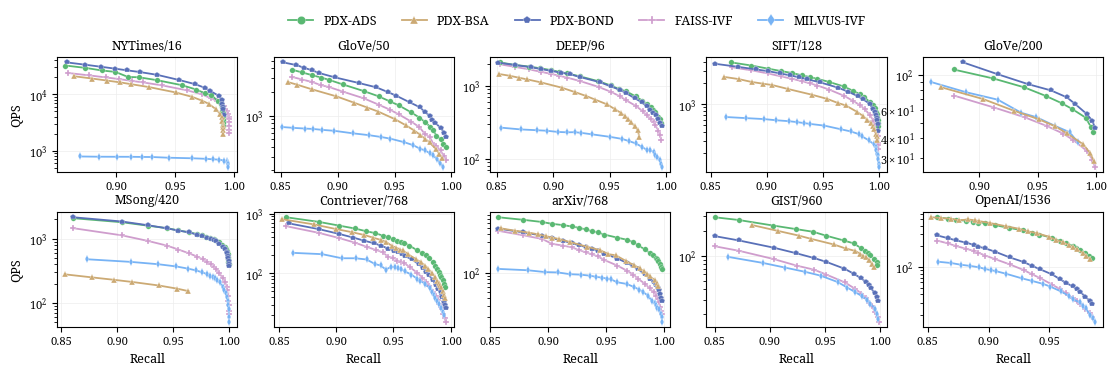

In [160]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import LogFormatter, FormatStrFormatter

colors = {
            'FAISS-IVF': '#cf9dcd',
            'MILVUS-IVF': '#77b3f5',
            'PDX-ADS': '#59b872',
            'PDX-BSA': '#ccaa74',
            'PDX-BOND': '#5970B8',
        }

dashes = {
            'FAISS-IVF': '',
            'MILVUS-IVF': '',
            'PDX-ADS': '',
            'PDX-BSA': '',
            'PDX-BOND': '',
}

order = list(range(len(df['Algorithm'].unique()))) # [1,2,0,3,4]

font = {'size': 8}
matplotlib.rc('font', **font)

fig, (
    (ax1, ax2, ax3, ax4, ax5),
    (ax9, ax10, ax11, ax12, ax13),
) = plt.subplots(2, 5)
fig.set_size_inches(13.5, 3.5)
plots = [ax1, ax2, ax3, ax4, ax5, ax9, ax10, ax11, ax12, ax13]

plt.subplots_adjust(hspace=0.35, wspace=0.20)

markers = ['P', 'd', 'o', 'p', '^']

order = [2, 4, 3, 0, 1]

for i, dataset in enumerate(list(DATASETS_MAPPING.keys())[:]):
    ax = plots[i]
    dataset_name = DATASETS_MAPPING[dataset]
    to_plot = df[df['Dataset'] == dataset]

    sns.lineplot(
        data=to_plot,
        x="Recall", 
        y="QPS",
        hue="Algorithm",
        markers=markers,
        dashes=dashes,
        palette=colors,
        style='Algorithm',
        linewidth=1.3,
        markeredgewidth=0.2,
        markersize=4,
        ax=ax,
    )
    
    ax.xaxis.grid(linewidth=0.5, color='#ededed')
    ax.yaxis.grid(linewidth=0.5, color='#ededed')
    ax.set_axisbelow(True)

    if (i == 0):
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            [handles[idx] for idx in order],[labels[idx] for idx in order],
            loc="upper left",
            prop={'size': 9},
            ncols=len(order),
            frameon=False,
            bbox_to_anchor=(1.22, 1.47),
            markerscale=1.5
        )
    
    ax.set_title(dataset_name, fontsize=9)
    ax.set_xlabel(f'Recall', fontsize=9)
    ax.set_ylabel('QPS', fontsize=9)
    
    if (i != 0):
        ax.legend().remove()
    if (i != 0 and i != 5):
        ax.set_ylabel('')
    if (i < 5):
        ax.set_xlabel('')
    if dataset_name not in ['STL/9216', 'Trevi/4096', 'HAR/561', 'F-MNIST/784']:
        ax.set_yscale('log')

plt.savefig(f'../figures/PDX_BOND_{arch}_tmp.png', format='png', dpi=600, bbox_inches='tight')

In [177]:
combined = linear.merge(
    pdx_bond, on=['dataset', 'ivf_nprobe'], how='inner', suffixes=('_faiss', '_bond')
).merge(
    pdx_ads, on=['dataset', 'ivf_nprobe'], how='inner', suffixes=('', '_ads')
).merge(
    pdx_bsa, on=['dataset', 'ivf_nprobe'], how='inner', suffixes=('', '_bsa')
).merge(
    milvus, on=['dataset', 'ivf_nprobe'], how='inner', suffixes=('', '_milvus')
)

HIGH_DATASETS_MAPPING = {
    'msong-420': 'MSong/420',
    'contriever-768': 'Contriever/768',
    'instructorxl-arxiv-768': 'arXiv/768',
    'gist-960-euclidean': 'GIST/960',
    'openai-1536-angular': 'OpenAI/1536',
}

combined = combined[['dataset', 'recall_faiss', 'ivf_nprobe', 'avg_faiss', 'avg_bond', 'avg', 'avg_bsa', 'avg_milvus']]
combined['avg_faiss'] = 1000 / combined['avg_faiss']
combined['avg_ads'] = 1000 / combined['avg']
combined['avg_bond'] = 1000 / combined['avg_bond']
combined['avg_bsa'] = 1000 / combined['avg_bsa']
combined['avg_milvus'] = 1000 / combined['avg_milvus']

# Taking the minimum nprobe to achieve the highest possible recall 
combined = combined[combined['recall_faiss'] < 0.90]
combined = combined.groupby(['dataset', 'recall_faiss']).last().reset_index().groupby(['dataset']).last().reset_index()
combined = combined[combined['dataset'].isin(list(DATASETS_MAPPING.keys()))]
#combined = combined[combined['dataset'].isin(list(HIGH_DATASETS_MAPPING.keys()))]

combined['speedup_ads_vs_faiss'] = combined['avg_ads'] / combined['avg_faiss']
combined['speedup_ads_vs_milvus'] = combined['avg_ads'] / combined['avg_milvus']
combined['speedup_ads_vs_bond'] = combined['avg_ads'] / combined['avg_bond']
combined['speedup_ads_vs_bsa'] = combined['avg_ads'] / combined['avg_bsa']

combined['speedup_bsa_vs_faiss'] = combined['avg_bsa'] / combined['avg_faiss']
combined['speedup_bsa_vs_bond'] = combined['avg_bsa'] / combined['avg_bond']

combined['speedup_bond_vs_faiss'] = combined['avg_bond'] / combined['avg_faiss']
combined['speedup_bond_vs_bsa'] = combined['avg_bond'] / combined['avg_bsa']
combined['speedup_bond_vs_milvus'] = combined['avg_bond'] / combined['avg_milvus']



print('Results for', arch)
print('Average Speedup of ADS against FAISS:', combined['speedup_ads_vs_faiss'].mean())
print('Average Speedup of ADS against MILVUS:', combined['speedup_ads_vs_milvus'].mean())
print('Average Speedup of ADS against BSA:', combined['speedup_ads_vs_bsa'].mean())
print('Average Speedup of ADS against BOND:', combined['speedup_ads_vs_bond'].mean())
print()
print('Average Speedup of BSA against FAISS:', combined['speedup_bsa_vs_faiss'].mean())
print('Average Speedup of BSA against BOND:', combined['speedup_bsa_vs_bond'].mean())
print()
print('Average Speedup of BOND against FAISS:', combined['speedup_bond_vs_faiss'].mean())
print('Average Speedup of BOND against MILVUS:', combined['speedup_bond_vs_milvus'].mean())
print('Average Speedup of BOND against BSA:', combined['speedup_bond_vs_bsa'].mean())
combined[[
    'dataset', 'recall_faiss', 'ivf_nprobe', 
    'speedup_ads_vs_faiss', 'speedup_ads_vs_bond', 'speedup_ads_vs_bsa', 
    'speedup_bsa_vs_faiss', 'speedup_bsa_vs_bond',
    'speedup_bond_vs_faiss', 'speedup_bond_vs_bsa'
]]

Results for SAPPHIRE
Average Speedup of ADS against FAISS: 1.638702852885159
Average Speedup of ADS against MILVUS: 7.330288941798763
Average Speedup of ADS against BSA: 1.1284849949102393
Average Speedup of ADS against BOND: 1.2642873172967584

Average Speedup of BSA against FAISS: 1.520135964405211
Average Speedup of BSA against BOND: 1.1744195691751984

Average Speedup of BOND against FAISS: 1.3242035822872258
Average Speedup of BOND against MILVUS: 7.228954397417032
Average Speedup of BOND against BSA: 1.019685374489403


,dataset,recall_faiss,ivf_nprobe,speedup_ads_vs_faiss,speedup_ads_vs_bond,speedup_ads_vs_bsa,speedup_bsa_vs_faiss,speedup_bsa_vs_bond,speedup_bond_vs_faiss,speedup_bond_vs_bsa
0,contriever-768,0.88480,8,1.525921,1.319652,1.102464,1.384101,1.197002,1.156306,0.835420
1,deep-image-96-angular,0.89790,24,1.126468,1.027965,1.195620,0.942162,0.859775,1.095823,1.163094
2,gist-960-euclidean,0.87210,32,2.331945,1.754901,0.979325,2.381177,1.791951,1.328818,0.558051
3,glove-200-angular,0.87870,80,1.459348,0.903401,1.289951,1.131321,0.700338,1.615393,1.427883
4,glove-50-angular,0.89225,28,1.234906,0.820954,1.148715,1.075033,0.714671,1.504234,1.399245
5,instructorxl-arxiv-768,0.89450,14,1.842655,1.631958,1.126315,1.636004,1.448936,1.129107,0.690161
6,msong-420,0.86080,6,1.431981,0.966605,0.920431,1.555772,1.050165,1.481455,0.952232
7,nytimes-16-angular,0.89132,22,1.323734,0.860208,1.389538,0.952643,0.619060,1.538854,1.615351
8,openai-1536-angular,0.89740,28,2.939081,2.312955,0.926526,3.172150,2.496372,1.270704,0.400581
9,sift-128-euclidean,0.88636,16,1.170989,1.044275,1.205965,0.970997,0.865925,1.121342,1.154835


# Camera Ready

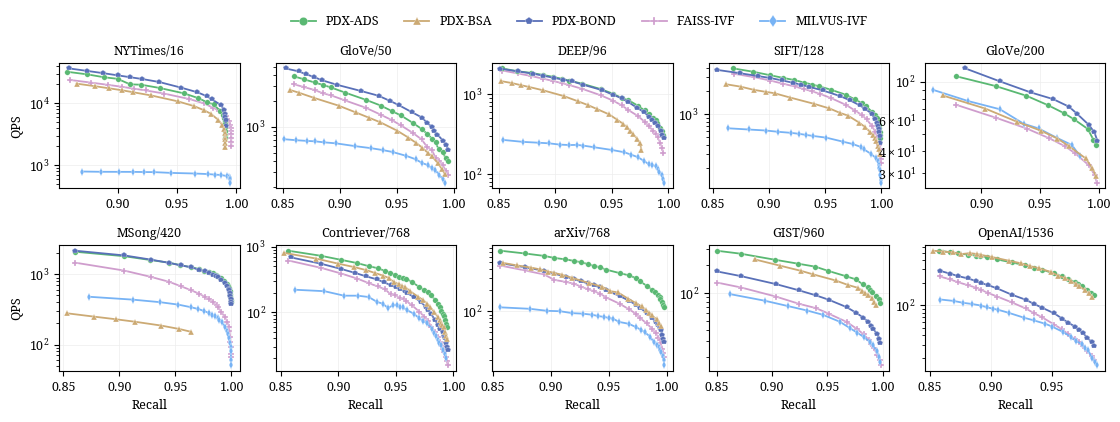

In [4]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import LogFormatter, FormatStrFormatter

colors = {
            'FAISS-IVF': '#cf9dcd',
            'MILVUS-IVF': '#77b3f5',
            'PDX-ADS': '#59b872',
            'PDX-BSA': '#ccaa74',
            'PDX-BOND': '#5970B8',
        }

dashes = {
            'FAISS-IVF': '',
            'MILVUS-IVF': '',
            'PDX-ADS': '',
            'PDX-BSA': '',
            'PDX-BOND': '',
}

order = list(range(len(df['Algorithm'].unique()))) # [1,2,0,3,4]

font = {'size': 9}
matplotlib.rc('font', **font)

fig, (
    (ax1, ax2, ax3, ax4, ax5),
    (ax9, ax10, ax11, ax12, ax13),
) = plt.subplots(2, 5)
fig.set_size_inches(13.5, 4.0)
plots = [ax1, ax2, ax3, ax4, ax5, ax9, ax10, ax11, ax12, ax13]

plt.subplots_adjust(hspace=0.45, wspace=0.20)

markers = ['P', 'd', 'o', 'p', '^']

order = [2, 4, 3, 0, 1]

for i, dataset in enumerate(list(DATASETS_MAPPING.keys())[:]):
    ax = plots[i]
    dataset_name = DATASETS_MAPPING[dataset]
    to_plot = df[df['Dataset'] == dataset]

    sns.lineplot(
        data=to_plot,
        x="Recall", 
        y="QPS",
        hue="Algorithm",
        markers=markers,
        dashes=dashes,
        palette=colors,
        style='Algorithm',
        linewidth=1.3,
        markeredgewidth=0.2,
        markersize=4,
        ax=ax,
    )
    
    ax.xaxis.grid(linewidth=0.5, color='#ededed')
    ax.yaxis.grid(linewidth=0.5, color='#ededed')
    ax.set_axisbelow(True)

    if (i == 0):
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            [handles[idx] for idx in order],[labels[idx] for idx in order],
            loc="upper left",
            prop={'size': 9},
            ncols=len(order),
            frameon=False,
            bbox_to_anchor=(1.22, 1.47),
            markerscale=1.5
        )
    
    ax.set_title(dataset_name, fontsize=9)
    ax.set_xlabel(f'Recall', fontsize=9)
    ax.set_ylabel('QPS', fontsize=9)
    
    if (i != 0):
        ax.legend().remove()
    if (i != 0 and i != 5):
        ax.set_ylabel('')
    if (i < 5):
        ax.set_xlabel('')
    if dataset_name not in ['STL/9216', 'Trevi/4096', 'HAR/561', 'F-MNIST/784']:
        ax.set_yscale('log')

plt.savefig(f'../figures/PDX_BOND_{arch}_cr.png', format='png', dpi=600, bbox_inches='tight')